In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import pickle
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'
ROOT = os.path.dirname(os.getcwd())

Firs I'm renormalizing all defensive metrics by opportunities - some features will be normalized by our possession, others by opponent's possession.  

Last time I had only normalized by our own possession so this is a slight pivot.

In [16]:
df = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'defensive_metrics_unnormalized.pkl.gz'))

atts_1 = ['yellow_card',
         'second_yellow_card',
         'total_fouls',
         'interception_total',
         'interception_inside_box',
         'sliding_tackle_total',
         'sliding_tackle_inside_box']

atts_2 = ['duels_lost',
          'duels_neutral',
          'duels_won',
          'dangerous_ball_lost']

df[atts_1] = df[atts_1].div(1 - df['possession'], axis=0)
df[atts_2] = df[atts_2].div(df['possession'], axis=0)
df = df.rename({c: c+'/possession' for c in atts_1+atts_2 if c != 'possession'}, axis=1)

defensive_metrics_normalized = df.copy()

In [17]:
#metrics
player_network_base = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'player_passing_networks_exploration.pkl.gz'))
zone_network_base = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zonal_passing_networks_exploration.pkl.gz'))
lane_intensity = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zone_lane_info_clustered.pkl.gz')) #includes cluster assignment for k=2
lane_cluster_centers = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'zone_lane_info_cluster_centers.pkl.gz')).sort_index()
advance_ratio = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'advance_ratio.pkl.gz'))
player_network_advanced = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'player_network_algorithms.pkl.gz'))


atts_defense = ['possession',
        'yellow_card/possession',
        'total_fouls/possession',
        'dangerous_ball_lost/possession',
        'interception_total/possession',
        'interception_inside_box/possession',
        'sliding_tackle_total/possession',
        'sliding_tackle_inside_box/possession',
        'fraction_slide_tackles_in_box',
        'fraction_interception_in_box',
        'centroid_slidetackles_interceptions_y',
        'centroid_slidetackles_interceptions_x',
        'fouls_committed',
        'yellow_card_per_foul_committed']

defensive_metrics_normalized  = defensive_metrics_normalized[atts_defense]


#Hadn't normalized this previously
defensive_metrics_normalized['fouls_committed'] = defensive_metrics_normalized['fouls_committed'].div(1 - defensive_metrics_normalized['possession'], axis=0)


#performance
match_goals_wins = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'matches_goals_wins.pkl.gz'))
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))

#Combining eveything
df = pd.concat([player_network_base,
                zone_network_base,
                lane_intensity[['cluster']].droplevel(1, axis=1).rename({'cluster': 'passing_lane_cluster'}, axis=1), #Only considering clusters for now
                advance_ratio,
                player_network_advanced,
                defensive_metrics_normalized], axis=1)
df = df.drop(columns = ['fouls_committed', 'yellow_card_per_foul_committed', 'possession', 'total_fouls/possession'])



#assert 0

#df = df.mean(level=1)
#assert 0
#Collapsing from per match to per team level
df = pd.concat([df.mean(level=1), df.var(level=1)],
         keys=['mean', 'var'], axis=1)

# Equal weightage in euclidean space for clustering
df = (df - df.mean())/df.std()
original_data = df.copy()
df

mean                                                          \
             w mean_passes_players std_passes_players mean_passes_zone   
1609  1.936797            1.993363           1.887977         2.009746   
1631 -0.569432           -0.571528          -0.468623        -0.579093   
1625  3.350016            3.406662           3.400785         3.017362   
1651 -0.698530           -0.603258          -0.754753        -0.715641   
1610  1.246287            1.251096           1.332306         1.599085   
...        ...                 ...                ...              ...   
3219 -0.183033           -0.253692           0.019928        -0.167924   
3193 -0.305870           -0.351561          -0.322652        -0.266909   
3315 -0.875034           -0.881524          -0.810637        -0.808535   
3163 -0.525306           -0.588668          -0.661436        -0.457265   
3165 -0.527990           -0.521211          -0.213069        -0.596352   

                                                         \
     std_passes_zone passing_lane_cluster advance_ratio   
1609        1.384351             2.020265      1.706638   
1631       -0.510147            -0.329204     -0.342721   
1625        3.390555             2.167107      2.126620   
1651       -0.826652            -1.797623     -0.300204   
1610        0.856457             0.698689      1.084321   
...              ...                  ...           ...   
3219       -0.085709            -0.182362      0.354051   
3193       -0.505610            -0.182362     -0.202459   
3315       -1.032875            -1.063413     -0.481081   
3163       -0.330596            -0.769730     -0.024488   
3165       -0.742170            -0.622888      0.124748   

                                                        \
     avg_clustering_coefficient algebraic_connectivity   
1609                   1.979335               0.942322   
1631                  -0.366233              -0.955545   
1625                   2.703903               2.277908   
1651                  -0.293391              -0.582852   
1610                   0.901086               1.193123   
...                         ...                    ...   
3219                  -0.072669              -0.575642   
3193                  -1.094088               0.391742   
3315                  -1.230323              -1.366720   
3163                  -0.780457               0.615376   
3165                  -0.288404              -1.454929   

                                  ...                    var  \
     avg_shortest_path_all_pairs  ... yellow_card/possession   
1609                   -1.666993  ...               1.653300   
1631                    0.619364  ...              -0.747483   
1625                   -2.465925  ...               5.826116   
1651                    0.665354  ...              -0.776794   
1610                   -1.402504  ...              -0.387114   
...                          ...  ...                    ...   
3219                    0.218342  ...              -0.423882   
3193                    0.086493  ...              -0.460864   
3315                    1.102206  ...              -0.767628   
3163                    0.321176  ...              -0.287397   
3165                    0.872364  ...               0.429964   

                                                                   \
     dangerous_ball_lost/possession interception_total/possession   
1609                       0.789182                      1.864124   
1631                      -0.359889                     -0.677239   
1625                      -0.534604                      2.415024   
1651                       1.014534                     -0.687970   
1610                      -0.036124                      2.522459   
...                             ...                           ...   
3219                       0.716250                      0.680410   
3193                       0.187168                      0.117889   
3

### What hapens if we use MI again, but try normalizing it to sum to 1?

In [18]:
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
performance = performance.set_index('area.name', append=True).swaplevel()[['name', 'end_of_season_pts']].sort_index()
performance['rank'] = performance.groupby(level=0).rank(pct=True)
performance['_quartile'] = pd.qcut(performance['rank'], q=4, labels=['q1', 'q2', 'q3', 'q4']) #q4 highest
performance = performance[['_quartile']].droplevel(0)
performance.columns = pd.MultiIndex.from_tuples([('performance', '_quartile')])
df = pd.concat([original_data, performance], axis=1)
df

mean                                                          \
              w mean_passes_players std_passes_players mean_passes_zone   
674   -0.167827           -0.156545           0.188738        -0.032391   
675    1.727497            1.767961           1.252692         1.505684   
676    2.079013            2.030195           1.509412         1.986903   
677   -0.521132           -0.532420          -0.667215        -0.631377   
678   -0.377127           -0.377986          -0.605593        -0.227823   
...         ...                 ...                ...              ...   
3795  -0.770384           -0.834326          -0.866550        -0.956759   
3799  -0.560786           -0.578889          -0.495295        -0.750159   
3804  -0.435862           -0.457505          -0.552697        -0.343559   
10531 -0.430794           -0.450675          -0.420584        -0.375032   
19830 -0.111776           -0.110309           0.231346        -0.027823   

                                                          \
      std_passes_zone passing_lane_cluster advance_ratio   
674         -0.042805             1.579740      1.098193   
675          0.570003             1.432898      1.697164   
676          1.604240             1.726581      1.793790   
677         -0.838640             0.111321     -0.062368   
678         -0.168287             0.551847     -0.537618   
...               ...                  ...           ...   
3795        -1.013445            -1.357097     -0.591535   
3799        -0.583421            -0.769730     -0.486048   
3804        -0.463759            -0.476046     -0.011533   
10531       -0.348876            -1.063413      0.096082   
19830        0.104544             1.139214      0.531511   

                                                         \
      avg_clustering_coefficient algebraic_connectivity   
674                    -0.805537              -0.349543   
675                     1.531757               2.719036   
676                     1.441253               0.828231   
677                    -0.578830               0.227737   
678                     0.656232               1.128884   
...                          ...                    ...   
3795                   -1.160048              -0.550204   
3799                   -0.725153              -1.050818   
3804                   -0.036585              -0.873047   
10531                  -0.860792              -0.798752   
19830                  -0.404672              -0.539892   

                                   ...                            var  \
      avg_shortest_path_all_pairs  ... dangerous_ball_lost/possession   
674                      0.221485  ...                       0.036879   
675                     -1.911460  ...                      -0.192688   
676                     -2.051108  ...                      -0.495791   
677                      0.308466  ...                      -0.039190   
678                     -0.003641  ...                       2.942776   
...                           ...  ...                            ...   
3795                     0.785490  ...                      -0.199119   
3799                     0.352757  ...                      -0.718988   
3804                     0.596591  ...                       0.128352   
10531                    0.574447  ...                       5.881079   
19830                    0.077187  ...                      -0.664660   

                                                                        \
      interception_total/possession interception_inside_box/possession   
674                        0.065545                          -0.286298   
675                        0.509499                           0.143202   
676                        1.742272                           0.943627   
677                        1.007455                          -0.104468   
678                       -1.204724                           0.026965   
...               

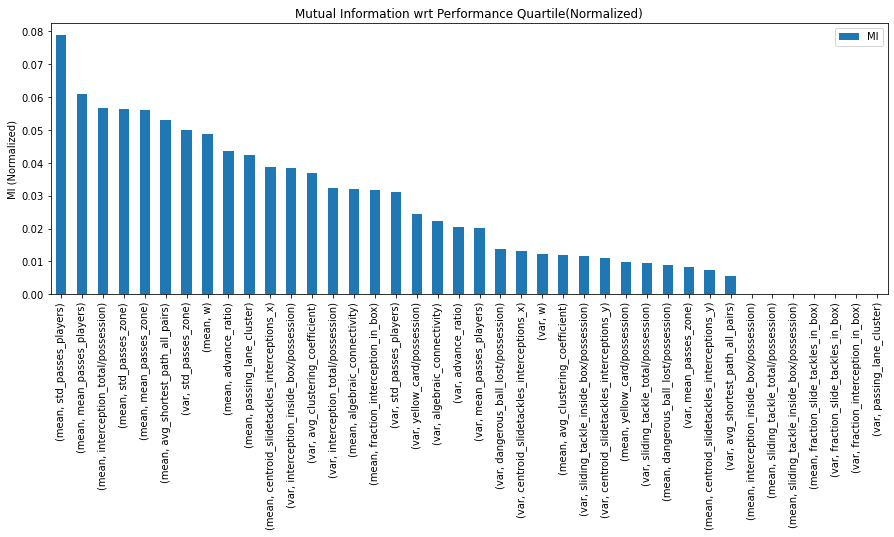

In [19]:
import sklearn.feature_selection
mutual_info = sklearn.feature_selection.mutual_info_classif(df[['mean', 'var']], df[['performance']].to_numpy().ravel())
mutual_info = pd.DataFrame(mutual_info, index=df.columns[:-1], columns=['MI'])
mutual_info = mutual_info / mutual_info.sum()
mutual_info.sort_values(by='MI', ascending=False).plot(kind='bar', figsize=(15, 5), title='Mutual Information wrt Performance Quartile(Normalized)')
plt.ylabel('MI (Normalized)')
#plt.xticks([i for i in range(40)], [i for i in range(40)])
plt.show()

## Hierarchical Clustering with normalized MI

In [20]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(15,5))
    dendrogram(linkage_matrix, **kwargs)


scaled_data = original_data.multiply(mutual_info['MI'], axis=1)

In [21]:
#atts = [c for c in scaled_data.columns if 'pass' in c[1] and 'passing' not in c[1]]
#scaled_data[atts] = scaled_data[atts] * 1/len(atts)

Text(0.5, 1.0, 'Dendrogram | Bottom Up Hierarchical Clustering')

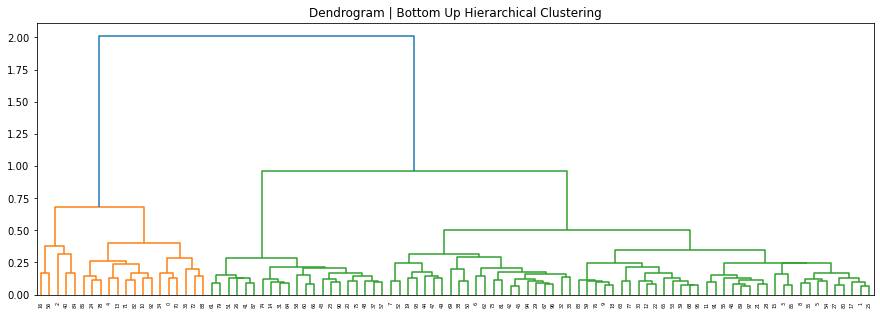

In [22]:
try:
    scaled_data = scaled_data.drop(columns='aggl_cluster')
except:
    pass

model = AgglomerativeClustering(compute_distances = True)
model.fit(scaled_data)
plot_dendrogram(model)
plt.title('Dendrogram | Bottom Up Hierarchical Clustering')

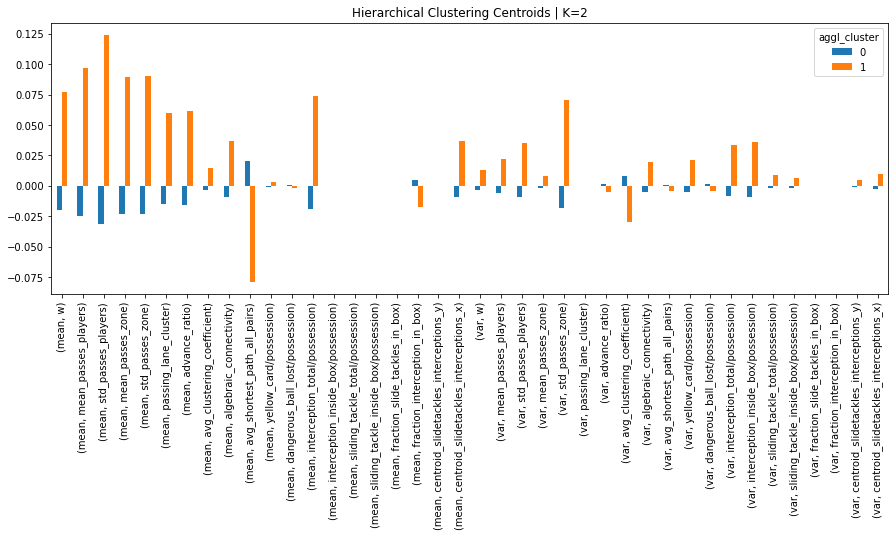

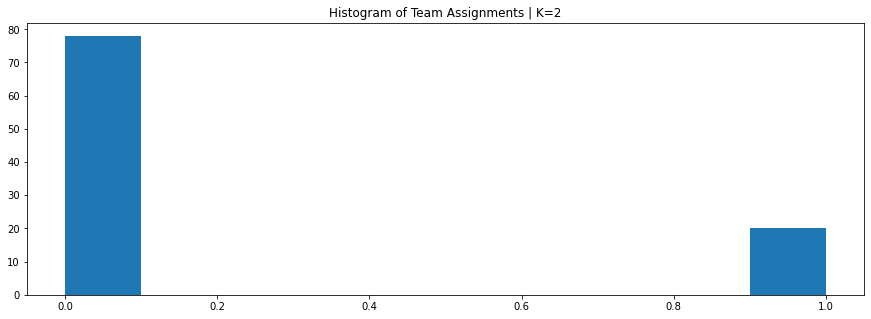

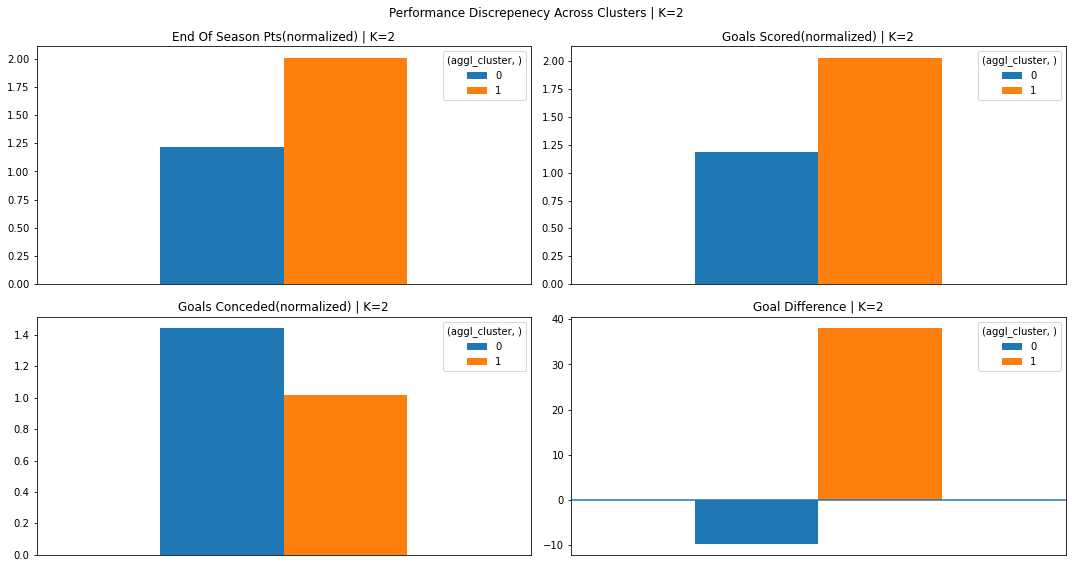

name                     
cluster             0                    1
0        Legan\u00e9s                Milan
1              Chievo              Chelsea
2                Metz    Tottenham Hotspur
3            Mainz 05           Real Betis
4         Montpellier              Arsenal
5             Burnley  Bayern M\u00fcnchen
6          Hoffenheim    Tottenham Hotspur
7              Chievo          Real Madrid
8         Southampton    Tottenham Hotspur
9               Lille            Liverpool

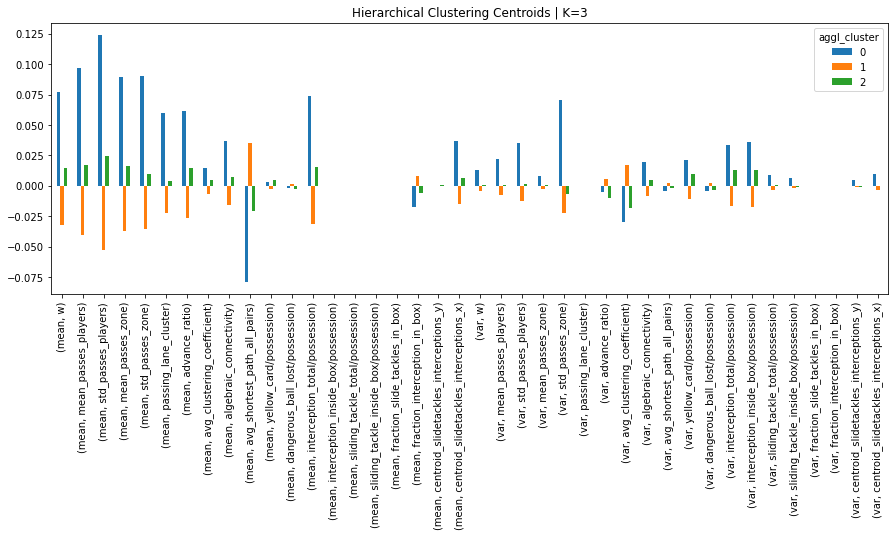

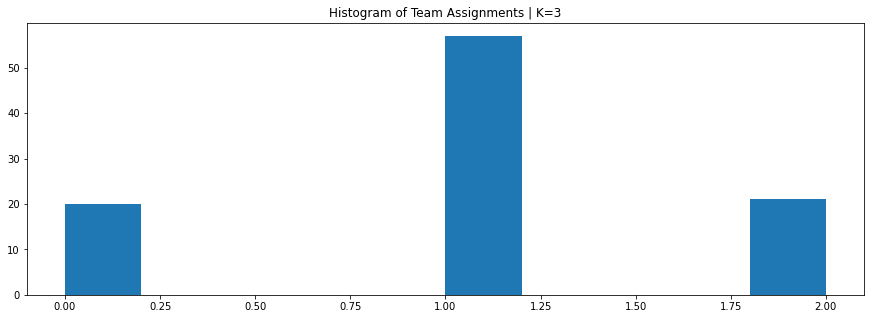

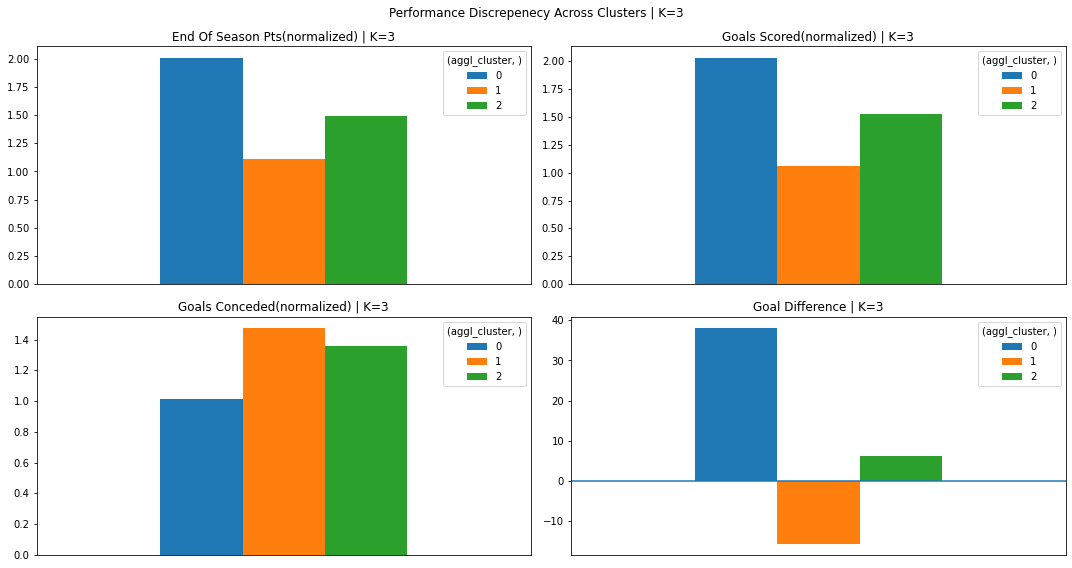

name                                     
cluster                  0                  1                 2
0           Internazionale        Hannover 96        RB Leipzig
1                     Nice       Swansea City  Bayer Leverkusen
2                    Milan             Rennes             Lille
3                    Milan           Augsburg          Atalanta
4        Tottenham Hotspur         Strasbourg        Hoffenheim
5                Barcelona          Benevento        RB Leipzig
6                Sampdoria  Huddersfield Town          Atalanta
7                     Roma          Stuttgart          Bordeaux
8        Tottenham Hotspur             Troyes             Lille
9              Real Madrid             Girona          Bordeaux

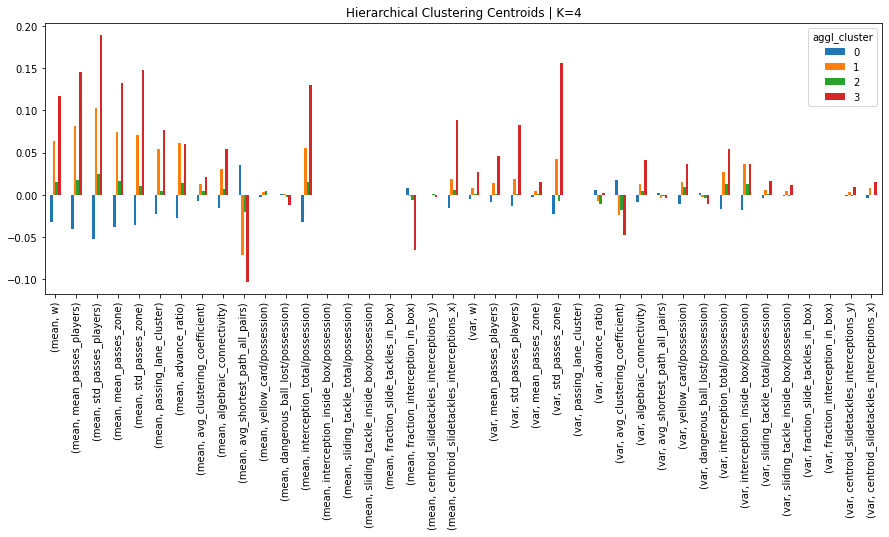

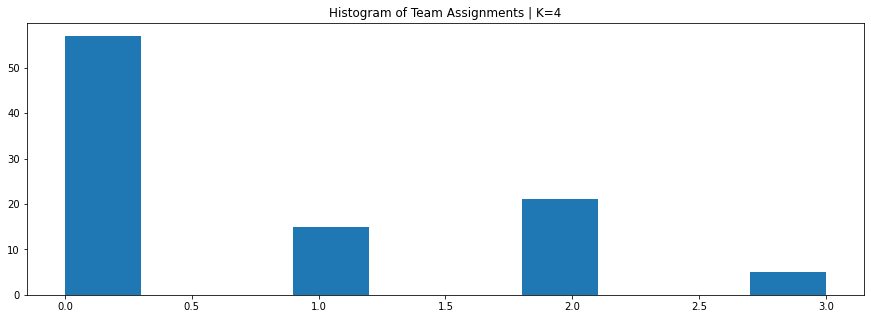

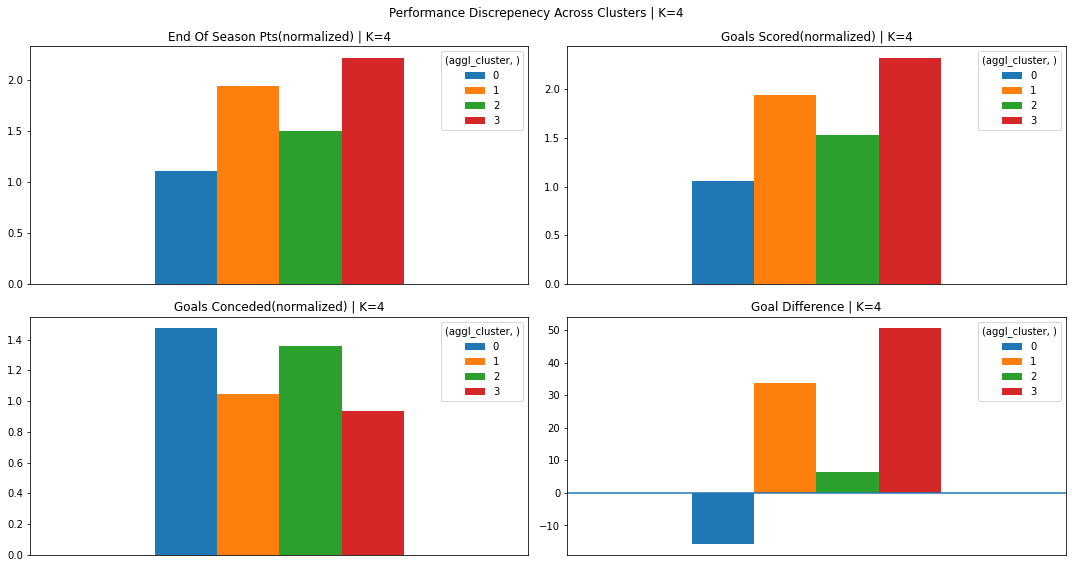

name                                           \
cluster                      0                   1                    2   
0        Deportivo Alav\u00e9s                Nice  Borussia M'gladbach   
1             Newcastle United            Juventus  Borussia M'gladbach   
2                    Benevento               Milan           Hoffenheim   
3                     Espanyol                 PSG        Celta de Vigo   
4             Newcastle United          Real Betis  Borussia M'gladbach   
5               Crystal Palace         Real Madrid  Borussia M'gladbach   
6          Eintracht Frankfurt                Nice  Borussia M'gladbach   
7                       Nantes  Olympique Lyonnais             Atalanta   
8                      Crotone          Real Betis        Celta de Vigo   
9                     Augsburg           Barcelona  Borussia M'gladbach   

                              
cluster                    3  
0            Manchester City  
1                     Napoli  
2                  Liverpool  
3                     Napoli  
4        Bayern M\u00fcnchen  
5            Manchester City  
6            Manchester City  
7                     Napoli  
8        Bayern M\u00fcnchen  
9                  Liverpool

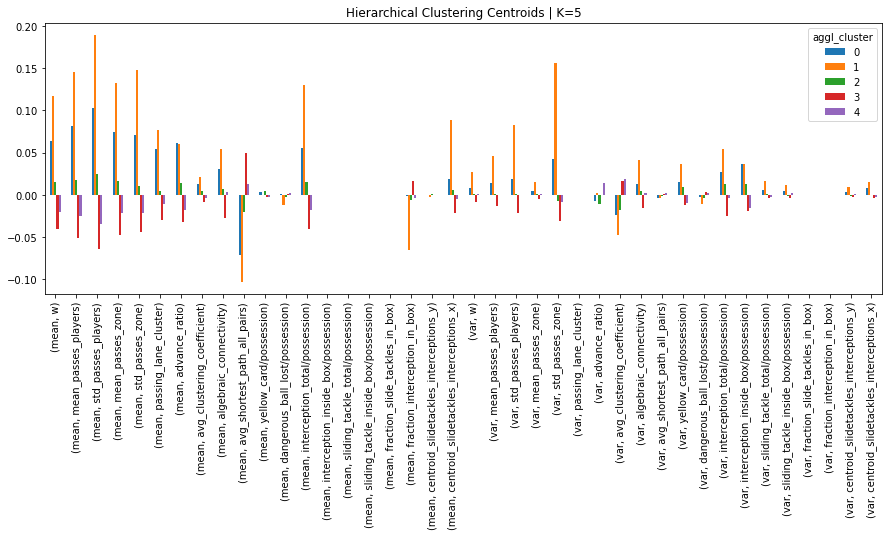

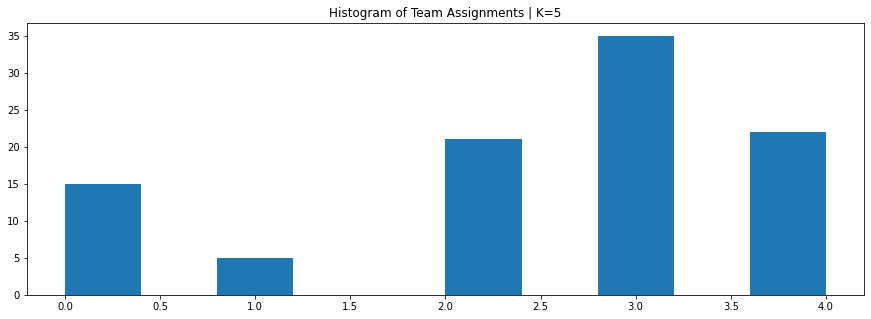

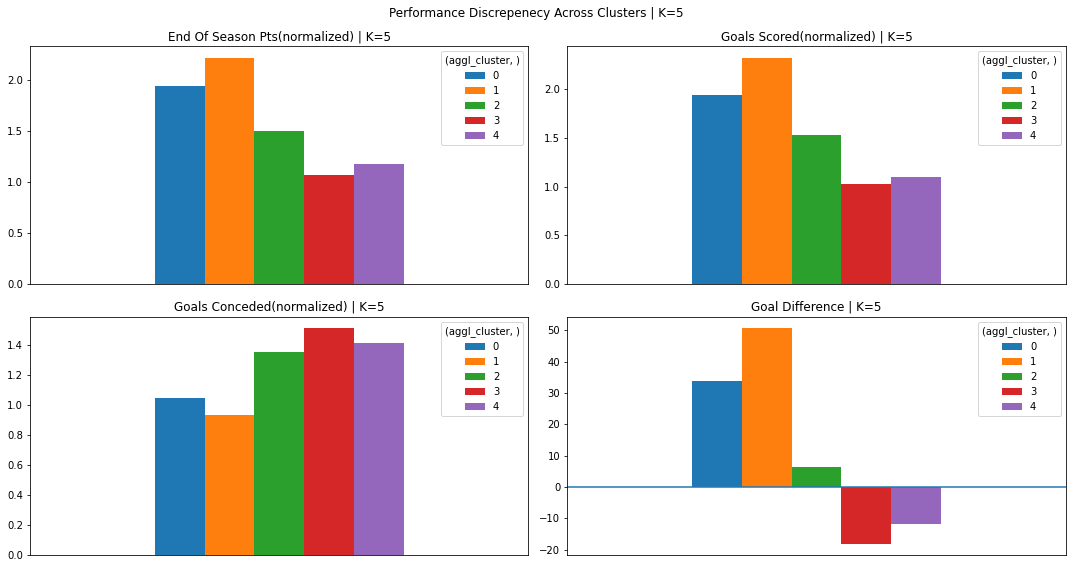

name                                            \
cluster                   0                    1                    2   
0                 Sampdoria            Liverpool              Sevilla   
1                 Barcelona  Bayern M\u00fcnchen              Sevilla   
2                      Nice               Napoli             Atalanta   
3                   Arsenal      Manchester City              Sevilla   
4                 Barcelona               Napoli            Wolfsburg   
5                       PSG            Liverpool  Olympique Marseille   
6         Manchester United               Napoli           Las Palmas   
7        Olympique Lyonnais               Napoli            Wolfsburg   
8                 Sampdoria      Manchester City     Bayer Leverkusen   
9            Internazionale               Napoli             Bordeaux   

                                                      
cluster                       3                    4  
0         Deportivo Alav\u00e9s               Rennes  
1                     Amiens SC      AFC Bournemouth  
2        Brighton & Hove Albion             Espanyol  
3                  Swansea City            Benevento  
4                  Legan\u00e9s            Stuttgart  
5                      Cagliari  Eintracht Frankfurt  
6         Deportivo Alav\u00e9s               Rennes  
7                        Girona                Genoa  
8                      Sassuolo        Athletic Club  
9                        Girona             Guingamp

In [23]:
perf =  pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
matches = pd.read_pickle(os.path.join(ROOT, 'processed_data', 'matches_df.pkl.gz'))[['team_home', 'team_away', 'goals_home', 'goals_away']].droplevel(1)
scored = matches.set_index('team_home')[['goals_home']].sum(level=0).rename({'goals_home': 'goals_scored'}, axis=1) + matches.set_index('team_away')[['goals_away']].sum(level=0).rename({'goals_away': 'goals_scored'}, axis=1)
conceded = matches.set_index('team_home')[['goals_away']].sum(level=0).rename({'goals_away': 'goals_conceded'}, axis=1) + matches.set_index('team_away')[['goals_home']].sum(level=0).rename({'goals_home': 'goals_conceded'}, axis=1)
matches = pd.concat([scored, conceded], axis=1)
matches['GD'] = matches['goals_scored'] - matches['goals_conceded']


for k in [2, 3, 4, 5]:

    try:
        scaled_data = scaled_data.drop(columns='aggl_cluster')
    except:
        pass

    model = AgglomerativeClustering(n_clusters=k, compute_distances=True)
    model.fit(scaled_data)
    scaled_data['aggl_cluster'] = model.labels_
    scaled_data.groupby('aggl_cluster').mean().T.plot(kind='bar', figsize=(15,5), title='Hierarchical Clustering Centroids | K={}'.format(k))
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.hist(model.labels_)
    plt.title('Histogram of Team Assignments | K={}'.format(k))
    plt.show()
    
        
    df = pd.concat([scaled_data[['aggl_cluster']], perf[['name', 'area.name','avg_pass_per_game', 'avg_shots_per_game', 'end_of_season_pts']], matches],
             axis=1)
    df = df.set_index(('aggl_cluster', ''))
    df.loc[df['area.name']=='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']] = df.loc[df['area.name']=='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']]/34
    df.loc[df['area.name']!='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']] = df.loc[df['area.name']!='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']]/38
    sample_assignments = df[['name']]
    #if k == 5:
        #assert 0
    #assert 0
    df = df.groupby(df.index).mean()
    
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
    df[['end_of_season_pts']].T.plot(kind='bar', title='End Of Season Pts(normalized) | K={}'.format(k), ax=axes[0, 0])
    df[['goals_scored']].T.plot(kind='bar', title='Goals Scored(normalized) | K={}'.format(k), ax=axes[0, 1])
    df[['goals_conceded']].T.plot(kind='bar', title='Goals Conceded(normalized) | K={}'.format(k), ax=axes[1, 0])
    df[['GD']].T.plot(kind='bar', title='Goal Difference | K={}'.format(k), ax=axes[1, 1])
    axes[1,1].axhline(0)
    
    for axx in axes:
        for ax in axx:
            ax.set_xticks([])
    
    plt.suptitle('Performance Discrepenecy Across Clusters | K={}'.format(k))
    plt.tight_layout()
    plt.show()
    
    sample_assignments = sample_assignments.groupby(sample_assignments.index).apply(pd.DataFrame.sample, n=10, replace=True).droplevel(1)
    sample_assignments = sample_assignments.reset_index().rename({('aggl_cluster', '') : 'cluster'}, axis=1)
    sample_assignments.index = [i%10 for i in sample_assignments.index]
    sample_assignments = sample_assignments.pivot(columns='cluster')
    display(sample_assignments)
    
    print('\n'*10)
    

### For K=4

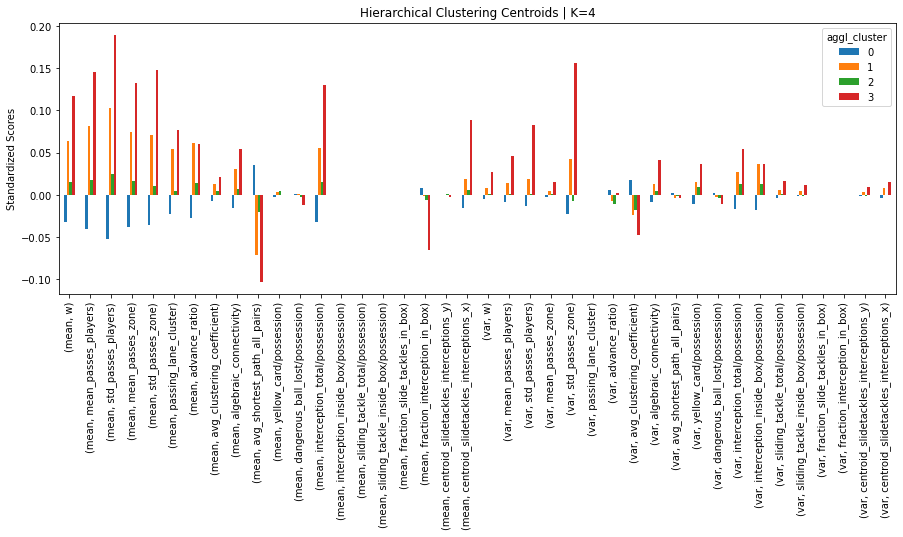

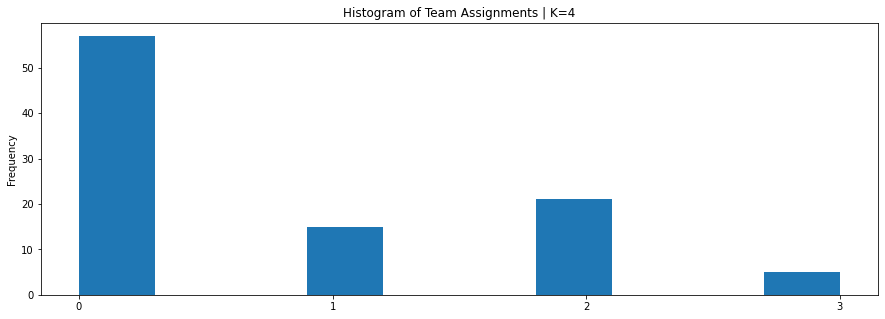

In [31]:
k=4
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
pezzali = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'pezzali.pkl.gz'))

performance = performance.set_index('area.name', append=True).swaplevel()[['name', 'end_of_season_pts']].sort_index()
performance['rank'] = performance.groupby(level=0).rank(ascending=False)
performance = performance.droplevel(0)
performance = pd.concat([performance, pezzali[['pezzali', 'conversion_rate']].mean(level=1)], axis=1)

model = AgglomerativeClustering(n_clusters=k, compute_distances=True)
scaled_data = scaled_data[[c for c in scaled_data.columns if c[0]!='aggl_cluster']]
model.fit(scaled_data)
scaled_data['aggl_cluster'] = model.labels_
scaled_data.groupby('aggl_cluster').mean().T.plot(kind='bar', figsize=(15,5), title='Hierarchical Clustering Centroids | K={}'.format(k))
#plt.xticks([i for i in range(40)], [i for i in range(40)])
plt.ylabel('Standardized Scores')
plt.show()

plt.figure(figsize=(15,5))
plt.hist(model.labels_)
plt.title('Histogram of Team Assignments | K={}'.format(k))
plt.ylabel('Frequency')
plt.xticks([i for i in range(4)], [i for i in range(4)])
plt.show()


df = pd.concat([scaled_data[['aggl_cluster']], perf[['name', 'area.name','avg_pass_per_game', 'avg_shots_per_game', 'end_of_season_pts']], matches, performance[['rank', 'pezzali', 'conversion_rate']]],
         axis=1)
df = df.set_index(('aggl_cluster', ''))
df.loc[df['area.name']=='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']] = df.loc[df['area.name']=='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']]/34
df.loc[df['area.name']!='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']] = df.loc[df['area.name']!='Germany', ['end_of_season_pts', 'goals_scored', 'goals_conceded']]/38
sample_assignments = df[['name']]
df.index.names = ['cluster']

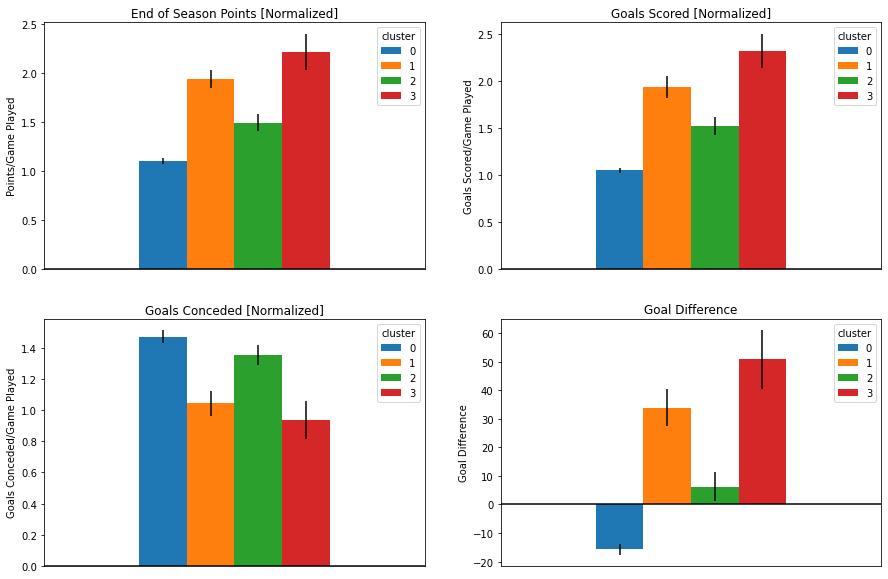

In [55]:
feats = ['end_of_season_pts', 'goals_scored', 'goals_conceded', 'GD']
labels = ['End of Season Points [Normalized]', 'Goals Scored [Normalized]', 'Goals Conceded [Normalized]', 'Goal Difference']
y_l = ['Points/Game Played', 'Goals Scored/Game Played', 'Goals Conceded/Game Played', 'Goal Difference']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, (feat, label, y_label) in enumerate(zip(feats, labels, y_l)):

    gd = df.groupby(df.index).mean()[[feat]]
    errors = df.groupby(df.index).sem()[[feat]]
    
    ax = axes[i//2, i%2] 

    gd.T.plot(yerr=errors.values, kind='bar', title=label, ax=ax)
    ax.set_ylabel(y_label)
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.axhline(0, color='k')
plt.show()

In [29]:
df.to_pickle(os.path.join(ROOT, 'intermediates', 'k_4_assignments.pkl.gz'))
scaled_data.to_pickle(os.path.join(ROOT, 'intermediates', 'k_4_data.pkl.gz'))

df

In [30]:
for cluster in range(4):

    display(df.loc[df.index==cluster].sort_values(by='end_of_season_pts', ascending=False)[['end_of_season_pts', 'rank', 'pezzali']])

,end_of_season_pts,rank,pezzali
cluster,,,
0,1.823529,2.0,0.911006
0,1.526316,5.0,0.884116
0,1.500000,7.0,1.142902
0,1.441176,8.0,1.087738
0,1.421053,7.0,1.494380
0,1.421053,9.5,1.527250
0,1.394737,8.0,0.805397
0,1.342105,9.0,0.669874
0,1.342105,9.5,0.604138


,end_of_season_pts,rank,pezzali
cluster,,,
1,2.500000,1.0,1.298187
1,2.447368,1.0,2.071840
1,2.447368,1.0,1.589880
1,2.131579,2.0,1.756791
1,2.052632,3.0,1.216111
1,2.026316,3.0,1.118992
1,2.026316,3.0,1.012240
1,2.000000,3.0,0.895705
1,1.894737,4.5,1.096307


,end_of_season_pts,rank,pezzali
cluster,,,
2,2.105263,2.0,1.800506
2,2.078947,2.0,1.457358
2,2.026316,4.0,1.059630
2,1.921053,4.0,1.208357
2,1.894737,4.5,1.594044
2,1.647059,3.0,1.207874
2,1.617647,4.5,1.230198
2,1.605263,5.0,1.288082
2,1.578947,7.0,0.978532


,end_of_season_pts,rank,pezzali
cluster,,,
3,2.631579,1.0,0.889747
3,2.470588,1.0,1.292192
3,2.394737,2.0,0.894945
3,1.973684,4.0,0.687979
3,1.617647,4.5,0.905849


# LEAVE THE REST BE FOR NOW, DIDNT GET ANYWHERE, DONT NEED THIS, MAY REVISIT LATER ON

### What's going on with Nice FC?

In [ ]:
df[(df.index==0) & (df['rank']==8)]

In [ ]:
performance = pd.read_pickle(os.path.join(ROOT, 'intermediates', 'team_performance.pkl.gz'))
idx = performance.loc[performance['name']=='Nice'].index[0]
scaled_data.loc[idx].to_frame().plot(kind='bar', figsize=(15, 5), title='Nice, France')
plt.show()
scaled_data.loc[scaled_data[('aggl_cluster', '')]==0].mean().plot(kind='bar', figsize=(15,5), title='C0 Centroid')
plt.show()

## Do K-Means and GMM converge?

Ie: How closely do the argmax of GMM and KMeans correlate?

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans


for init_type in ['kmeans', 'random']:


    try:
        scaled_data = scaled_data.drop(columns='aggl_cluster')
    except:
        pass

    gmm = GMM(n_components=3, verbose=1, init_params=init_type, covariance_type='tied', random_state=0)
    gmm.fit(scaled_data)

    means = pd.DataFrame(gmm.means_, columns=scaled_data.columns)
    means.T.plot(kind='bar', figsize=(15, 5), title='GMM | Init Type: {}'.format(init_type))
    plt.show()


    kmeans_classifier = KMeans(n_clusters=3, random_state=0).fit(scaled_data)
    cluster_centers = pd.DataFrame(kmeans_classifier.cluster_centers_).iloc[:, :].T
    cluster_centers.index = scaled_data.columns
    cluster_centers.plot(kind='bar', figsize=(15, 5))
    plt.title('KMeans')
    plt.show()

    combined = pd.concat([pd.Series(gmm.predict(scaled_data)), pd.Series(kmeans_classifier.predict(scaled_data))], axis=1, keys=['GMM', 'KMeans'])
    idx_2 = combined['GMM'][combined['GMM']==2].index
    idx_0 = combined['GMM'][combined['GMM']==0].index
    
    #if init_type == 'random': assert 0

    combined.loc[idx_0, 'GMM'] = 2
    combined.loc[idx_2, 'GMM'] = 0

    print('Matching', (combined['GMM'] == combined['KMeans']).sum())
    print('Total', combined.shape[0])
    
    display(pd.DataFrame(gmm.predict_proba(scaled_data), index=scaled_data.index))
    
    print('\n' * 10)
